# Laboratorio 4
- Juan Pablo Solis
- Brandon Reyes
- Carlos Valladares

Link Github: https://github.com/JPS4321/Lab4_IA

# Task 1 - Preguntas Teoricas
1. Explique con sus propias palabras, qué son los grafos computaciones y cuál es su importancia para el
cálculo de gradientes en aplicaciones como backpropagation.
    - Un grafo computacional es un tipo de grafico el cual su nodo raiz representa la expresión matemática final y cada nodo representa subexpresiones intermedias
2. Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo
mejoraría el perceptrón que hizo en el laboratorio pasado?
    - Neuronas: Unidades básicas que procesan información a través de funciones de activación.
    - Capas: Incluyen capa de entrada, capas ocultas y capa de salida.
    - Pesos y sesgos: Factores que determinan la influencia de una neurona en otra.
    - Función de activación: Introduce no linealidad en la red (ReLU, Sigmoide, etc.).
    - Función de costo: Mide la diferencia entre la salida esperada y la obtenida.
    - Algoritmo de optimización: Como el descenso de gradiente para actualizar los pesos.
    - Para mejorar el perceptron añadiendo más capas ocultas y utilizando funciones de activación no lineales
3. Investigue y explique cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K-
Means
    - El método del coeficiente de silueta mide la calidad de los clusters evaluando la similitud de cada punto con su propio cluster y comparándola con otros clusters
    - La ecuacion es S(i)= (b(i)−a(i))/(max(a(i),b(i)))
    - Donde a(i) es la distancia promedio del punto i a los demás puntos de su mismo cluster y b(i) es la menor distancia promedio del punto i a los puntos de otro cluster.
4. ¿Cómo podría ayudarle el PCA a mejorar la calidad de sus clusters cuando se usa K-Means?
    - El PCA ayuda a reducir la dimensionalidad de los datos preservando la varianza más significativa, por lo que puede mejorar significativamente los resultados de K-Means al facilitar la identificación de patrones relevantes en los datos
​


# Task 2.1 K-Means y Segmentación de Clientes de Banco

## 2.1.0 Exploracion e Importacion de datos

In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


#### Exploracion Inicial

In [2]:
filepath = "bank_transactions.csv"
df = pd.read_csv(filepath)
#Exploracion de datos - Inciso 2.0
print("Distribución inicial de la columna 'Genero':")
print(df['CustGender'].value_counts())
print("\nVerificacion de datos nulos")
print(df.isnull().sum())
print("\nResumen estadistico de los datos")
print(df.describe())




Distribución inicial de la columna 'Genero':
CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64

Verificacion de datos nulos
TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Resumen estadistico de los datos
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05

Eliminacion De Datos Nulos

In [3]:
# Eliminar filas con valores nulos en las columnas especificadas
df = df.dropna()
print("\nVerificacion de datos nulos")
print(df.isnull().sum())


Verificacion de datos nulos
TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


Filtracion de Columnas

In [4]:
selected_features = ['CustomerDOB', 'CustGender', 'CustAccountBalance', 'TransactionAmount (INR)']
df = df[selected_features]

In [5]:
# Eliminar filas donde el género sea 'T'
df = df[df["CustGender"] != "T"]

label_encoder = LabelEncoder()

# Aplicar Label Encoding a la columna 'CustGender' (M -> 1, F -> 0)
df["CustGender"] = label_encoder.fit_transform(df["CustGender"])




Encoding y Escalamiento de Columnas

In [6]:
from datetime import datetime

current_year = datetime.now().year
df["CustomerDOB"] = pd.to_datetime(df["CustomerDOB"], errors='coerce', format="%d/%m/%y")

# Calcular la edad a partir de 'CustomerDOB'
df["Age"] = current_year - df["CustomerDOB"].dt.year
df.loc[df['Age'] < 0, 'Age'] += 100

# Eliminar la columna original 'CustomerDOB' ya que ahora tenemos 'Age'
df.drop(columns=["CustomerDOB"], inplace=True)



In [7]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ["CustAccountBalance", "TransactionAmount (INR)", "Age"]
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


In [8]:
# Contar la cantidad de registros por género (ahora en formato numérico)
gender_counts = df["CustGender"].value_counts()
min_class = gender_counts.min()  # Número de registros en la clase minoritaria

# Separar por género usando los valores numéricos
df_male = df[df["CustGender"] == 1]  # M
df_female = df[df["CustGender"] == 0]  # F

# Balancear mediante undersampling (reducimos la clase mayoritaria al tamaño de la minoritaria)
df_male_balanced = resample(df_male, replace=False, n_samples=min_class, random_state=42)
df_female_balanced = resample(df_female, replace=False, n_samples=min_class, random_state=42)

# Combinar ambos para formar el dataset balanceado
df_balanced = pd.concat([df_male_balanced, df_female_balanced])

# Mezclar las filas aleatoriamente para evitar sesgos
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balancedCopy = df_balanced.copy()

print(df_balanced['CustGender'].value_counts())


CustGender
0    280635
1    280635
Name: count, dtype: int64


In [9]:
# Seleccionar solo las primeras columnas para mostrar
df_head = df.iloc[:, :4]  # Tomamos las primeras 5 columnas

# Mostrar los datos
df_head

,CustGender,CustAccountBalance,TransactionAmount (INR),Age
0,0,-0.114766,-0.234869,-1.031434
1,1,-0.133128,4.028554,3.197174
2,0,-0.114701,-0.168724,-1.260008
3,0,0.887505,0.075279,1.368587
4,0,-0.127881,0.029938,-0.345714
...,...,...,...,...
1048562,1,-0.126793,-0.116906,-0.574287
1048563,1,-0.103556,-0.168572,-0.802861
1048564,1,0.126079,-0.121326,-0.460001
1048565,1,-0.123861,-0.086272,0.797153


2.1.1 Entrenamiento de Modelo K-Means

#### Entrenamiento Sin librerias

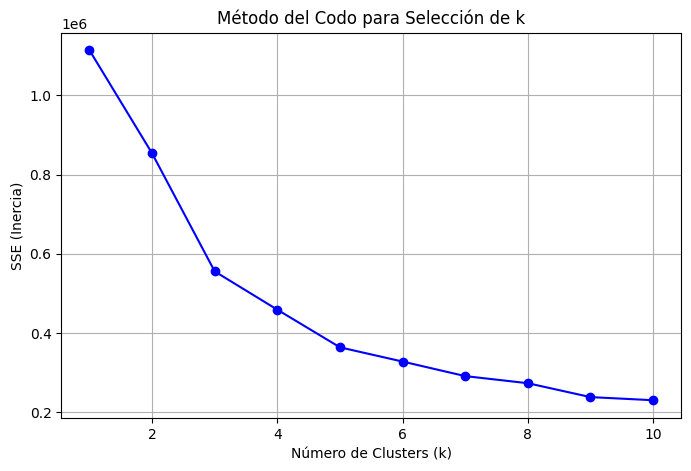

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Implementación alternativa de K-Means sin librerías externas
def k_means_custom(X, k, max_iters=100):
    n_samples = X.shape[0]
    centroids = X[np.random.choice(n_samples, k, replace=False)]  # Inicializar centroides aleatorios
    
    for _ in range(max_iters):
        # Calcular distancias euclidianas
        distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
        
        # Asignar cada punto al cluster más cercano
        cluster_assignments = np.argmin(distances, axis=1)
        
        # Calcular nuevos centroides
        new_centroids = np.array([X[cluster_assignments == i].mean(axis=0) if np.any(cluster_assignments == i) 
                                  else X[np.random.choice(n_samples)] 
                                  for i in range(k)])
        
        # Verificar convergencia
        if np.allclose(centroids, new_centroids):
            break
        
        centroids = new_centroids

    # Calcular la inercia (suma de distancias al cuadrado dentro de los clusters)
    sse = np.sum((X - centroids[cluster_assignments]) ** 2)
    
    return centroids, cluster_assignments, sse

# Función para aplicar el método del codo y encontrar el número óptimo de clusters
def elbow_method_custom(X, max_k=10):
    inertia_scores = []
    for k in range(1, max_k + 1):
        _, _, sse = k_means_custom(X, k)
        inertia_scores.append(sse)
    return inertia_scores

# Aplicar el método del codo a dos características seleccionadas
X_selected = df_balanced[['CustAccountBalance', 'TransactionAmount (INR)']].values
inertia_scores = elbow_method_custom(X_selected, max_k=10)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(inertia_scores) + 1), inertia_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("SSE (Inercia)")
plt.title("Método del Codo para Selección de k")
plt.grid(True)
plt.show()


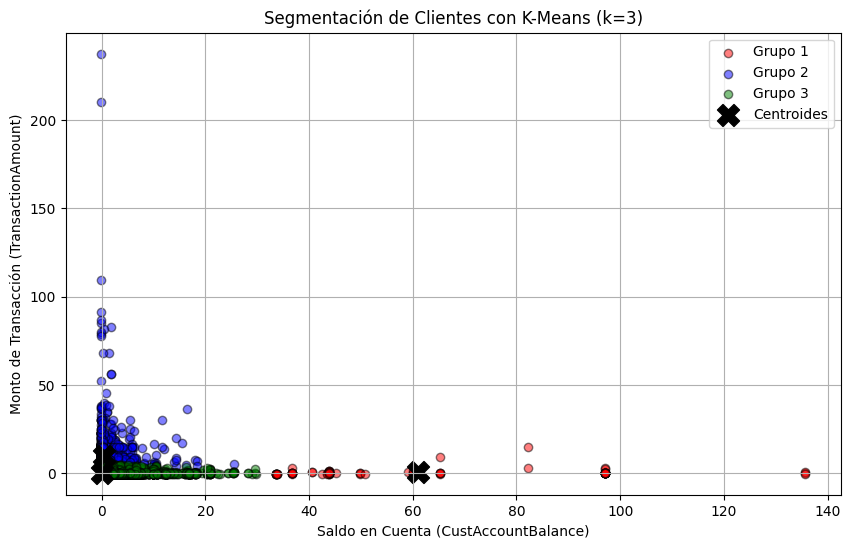

Coeficiente de Silhouette: 0.9603


In [11]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Definir el número de clusters según el método del codo
k_optimo = 3  

# Aplicar K-Means con el número óptimo de clusters
centroids, labels, _ = k_means_custom(X_selected, k_optimo)

# Colores para los clusters
cluster_colors = ['red', 'blue', 'green']

plt.figure(figsize=(10, 6))

# Graficar cada cluster con sus puntos
for cluster_id in range(k_optimo):
    plt.scatter(
        X_selected[labels == cluster_id, 0],
        X_selected[labels == cluster_id, 1],
        color=cluster_colors[cluster_id], 
        label=f'Grupo {cluster_id + 1}', 
        alpha=0.5, edgecolors='k'
    )

# Graficar los centroides
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    color='black', marker='X', s=250, label="Centroides"
)

# Etiquetas y título
plt.xlabel('Saldo en Cuenta (CustAccountBalance)')
plt.ylabel('Monto de Transacción (TransactionAmount)')
plt.title(f'Segmentación de Clientes con K-Means (k={k_optimo})')
plt.legend()
plt.grid(True)
plt.show()

# Calcular y mostrar el coeficiente de Silhouette
silhouette_avg = silhouette_score(X_selected, labels, sample_size= 5000,random_state=5)
print(f"Coeficiente de Silhouette: {silhouette_avg:.4f}")


### Con Libreria

C:\Users\brand\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\brand\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wi

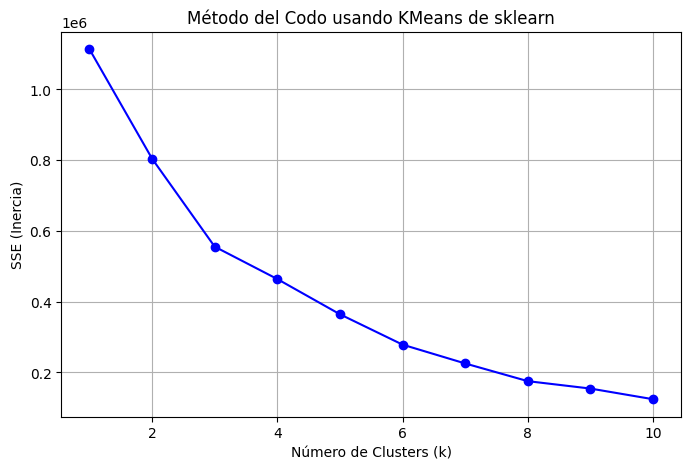

In [12]:
from sklearn.cluster import KMeans

# Aplicar el método del codo usando KMeans de sklearn
def elbow_method_sklearn(X, max_k=10):
    inertia_scores = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, random_state=42)
        kmeans.fit(X)
        inertia_scores.append(kmeans.inertia_)
    return inertia_scores

# Aplicar el método del codo a dos características seleccionadas
X_selected = df_balancedCopy[['CustAccountBalance', 'TransactionAmount (INR)']].values
inertia_scores = elbow_method_sklearn(X_selected, max_k=10)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(inertia_scores) + 1), inertia_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("SSE (Inercia)")
plt.title("Método del Codo usando KMeans de sklearn")
plt.grid(True)
plt.show()



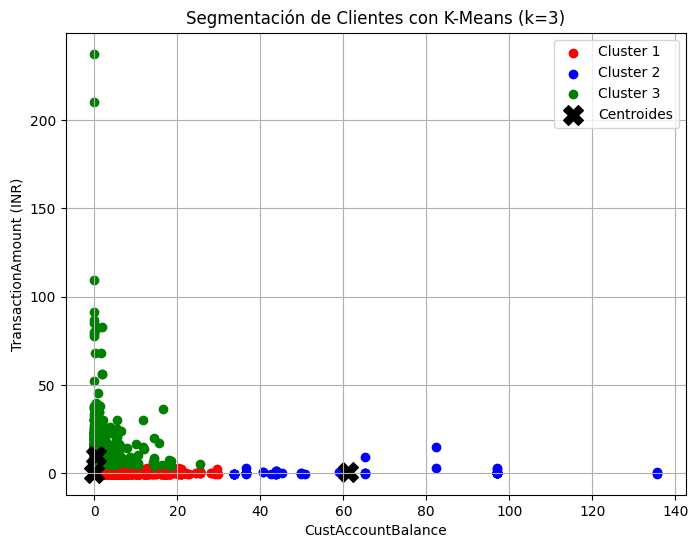

Silhouette Score: 0.9603


In [13]:
# Seleccionar el número óptimo de clusters (usaremos k=3 basado en el método del codo)
optimal_k = 3

# Aplicar KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", max_iter=300, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_selected)
centroids = kmeans.cluster_centers_

# Graficar los clusters
plt.figure(figsize=(8, 6))
colors = np.array(["red", "blue", "green", "orange", "purple"])

for i in range(optimal_k):
    plt.scatter(X_selected[labels == i, 0], X_selected[labels == i, 1], color=colors[i], label=f"Cluster {i+1}")

# Graficar centroides
plt.scatter(centroids[:, 0], centroids[:, 1], color="black", marker="X", s=200, label="Centroides")

plt.xlabel("CustAccountBalance")
plt.ylabel("TransactionAmount (INR)")
plt.title("Segmentación de Clientes con K-Means (k=3)")
plt.legend()
plt.grid(True)
plt.show()

silhouette_avg = silhouette_score(X_selected, labels, sample_size= 5000,random_state=5)
print(f"Silhouette Score: {silhouette_avg:.4f}")



Comparacion Libreria con Sin libreria
- Se puede observar que aunque los resultados fueron extremadamente similares, por no decir identicos, la principal diferencia es la optimizacion que tiene la libreria de Kmeans, haciendo que el tiempo de ejecucion pase de 40 segundos sin librerias a 2 segundos usando la libreria

# Task 2.2.1


## SIN librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Cargar datos
def cargar_datos(file_path):
    df = pd.read_csv(file_path)
    
    # Convertir fecha de nacimiento a edad
    def calcular_edad(fecha_nac):
        try:
            anio = int(str(fecha_nac).split('/')[-1])
            return 2025 - (1900 + anio) if anio < 100 else 2025 - anio
        except:
            return np.nan

    df['Edad'] = df['CustomerDOB'].apply(calcular_edad)
    df.dropna(subset=['Edad', 'CustAccountBalance', 'TransactionAmount (INR)'], inplace=True)
    
    # Seleccionar variables y normalizar
    features = ['Edad', 'CustAccountBalance', 'TransactionAmount (INR)']
    X = df[features].values
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    return X, df

In [18]:
# Implementación de la distribución normal multivariada
def multivariate_gaussian(X, mean, cov):
    n = X.shape[1]
    diff = X - mean
    inv_cov = np.linalg.pinv(cov + np.eye(n) * 1e-6)  # Usar pseudo-inversa para evitar errores numéricos
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    coef = 1 / (np.sqrt((2 * np.pi) ** n * np.linalg.det(cov + np.eye(n) * 1e-6)))
    return coef * np.exp(exponent)

# Implementación manual de Gaussian Mixture Models (GMM)
class GaussianMixtureModelManual:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights = np.full(self.n_components, 1 / self.n_components)
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]
        self.covariances = np.array([np.cov(X.T) for _ in range(self.n_components)])

    def expectation_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_gaussian(X, self.means[k], self.covariances[k])

        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True) + 1e-6  # Evitar división por cero
        return responsibilities

    def maximization_step(self, X, responsibilities):
        n_samples = X.shape[0]
        for k in range(self.n_components):
            Nk = responsibilities[:, k].sum()
            self.means[k] = np.sum(responsibilities[:, k][:, np.newaxis] * X, axis=0) / Nk
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk + np.eye(X.shape[1]) * 1e-6
            self.weights[k] = Nk / n_samples

    def fit(self, X):
        self.initialize_parameters(X)
        prev_likelihood = None

        for _ in range(self.max_iter):
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)
            log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1) + 1e-6))  # Evitar log(0)

            if prev_likelihood is not None and abs(log_likelihood - prev_likelihood) < self.tol:
                break
            prev_likelihood = log_likelihood

    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)
    


# Selección del número óptimo de clusters utilizando BIC
def calcular_bic(X, modelo):
    n_samples, n_features = X.shape
    n_params = modelo.n_components * (n_features + n_features * (n_features + 1) / 2)
    log_likelihood = np.sum(np.log(np.sum(modelo.expectation_step(X), axis=1) + 1e-6))
    return np.log(n_samples) * n_params - 2 * log_likelihood

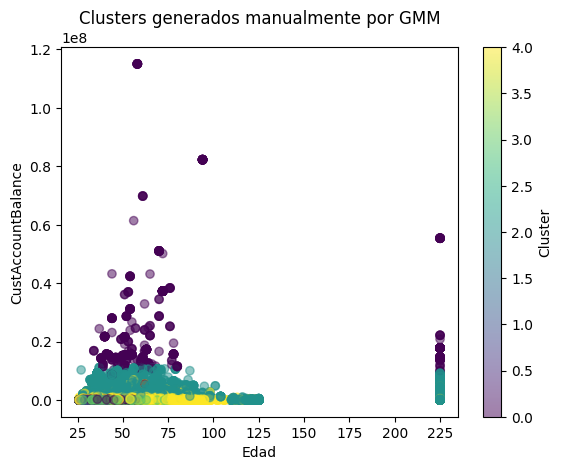

Mejor número de clusters según BIC: 5
   Edad  CustAccountBalance  TransactionAmount (INR)  Cluster
0  31.0            17819.05                     25.0        1
1  68.0             2270.69                  27999.0        4
2  29.0            17874.44                    459.0        3
3  52.0           866503.21                   2060.0        4
4  37.0             6714.43                   1762.5        0


In [19]:
if __name__ == "__main__":
    file_path = "bank_transactions.csv"
    X, df = cargar_datos(file_path)
    
    # Seleccionar el mejor número de clusters basado en BIC
    best_k = 2
    best_bic = float("inf")
    for k in range(2, 6):
        modelo = GaussianMixtureModelManual(n_components=k)
        modelo.fit(X)
        bic = calcular_bic(X, modelo)
        if bic < best_bic:
            best_bic = bic
            best_k = k
    
    # Entrenar el modelo final con el mejor número de clusters
    gmm = GaussianMixtureModelManual(n_components=best_k)
    gmm.fit(X)
    df['Cluster'] = gmm.predict(X)
    
    # Visualización de clusters
    plt.scatter(df['Edad'], df['CustAccountBalance'], c=df['Cluster'], cmap='viridis', alpha=0.5)
    plt.xlabel('Edad')
    plt.ylabel('CustAccountBalance')
    plt.title('Clusters generados manualmente por GMM')
    plt.colorbar(label='Cluster')
    plt.show()
    
    # Mostrar los resultados con el número óptimo de clusters
    print(f"Mejor número de clusters según BIC: {best_k}")
    print(df[['Edad', 'CustAccountBalance', 'TransactionAmount (INR)', 'Cluster']].head())


## CON Librerías

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Cargar datos
file_path = "bank_transactions.csv"
df = pd.read_csv(file_path)

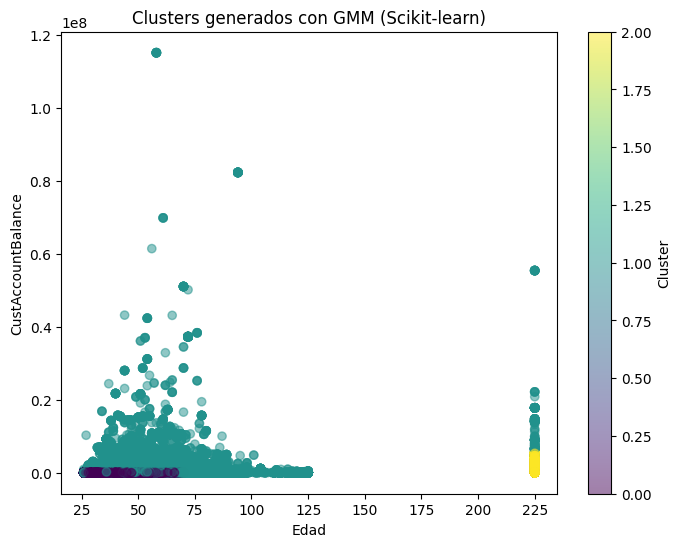

In [21]:

def calcular_edad(fecha_nac):
    try:
        anio = int(str(fecha_nac).split('/')[-1])
        return 2025 - (1900 + anio) if anio < 100 else 2025 - anio
    except:
        return np.nan

# Aplicar la función para calcular la edad
df['Edad'] = df['CustomerDOB'].apply(calcular_edad)

# Eliminar valores nulos
df.dropna(subset=['Edad', 'CustAccountBalance', 'TransactionAmount (INR)'], inplace=True)

# Seleccionar las variables relevantes
features = ['Edad', 'CustAccountBalance', 'TransactionAmount (INR)']
X = df[features].values

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar Gaussian Mixture Models (GMM) con Scikit-learn
best_k = 3
gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm.fit(X_scaled)
df['Cluster'] = gmm.predict(X_scaled)

# Visualización de clusters
plt.figure(figsize=(8, 6))
plt.scatter(df['Edad'], df['CustAccountBalance'], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Edad')
plt.ylabel('CustAccountBalance')
plt.title('Clusters generados con GMM (Scikit-learn)')
plt.colorbar(label='Cluster')
plt.show()

### 1. Split del Dataset y Enfoque de Aprendizaje No Supervisado

Dado que el objetivo es la segmentación de clientes sin etiquetas predefinidas, se mantuvo un enfoque de aprendizaje no supervisado. No se dividió el dataset en entrenamiento y prueba, ya que en clustering buscamos descubrir patrones sin necesidad de una validación supervisada. Además, se normalizaron las variables para que todas tengan una escala similar y evitar que alguna predomine sobre las demás durante el proceso de agrupación.

### 2. Selección del Número de Clusters con BIC

Para determinar la cantidad óptima de clusters, se usó el criterio de información bayesiano (BIC). Este método equilibra la verosimilitud del modelo con su complejidad, evitando el sobreajuste. Se probaron distintos valores de K (de 2 a 6) y se eligió el que minimiza BIC, asegurando un modelo flexible que capta bien la estructura de los datos sin volverse excesivamente complejo.

### 3. Justificación del Uso de PCA

El Análisis de Componentes Principales (PCA) puede ser útil en este caso porque ayuda a reducir la dimensionalidad del dataset, eliminando redundancias y facilitando la segmentación. Aplicar PCA permitiría visualizar los clusters en dos dimensiones sin perder demasiada información relevante. Además, reducir la dimensionalidad puede mejorar la estabilidad numérica y acelerar la convergencia del modelo.

### 4. Visualización de los Clusters

Se eligieron Edad y CustAccountBalance como las variables clave para la visualización, ya que ambas son indicadores relevantes en la segmentación de clientes bancarios. Se usó matplotlib únicamente para representar la distribución de los clusters, aplicando una escala de colores que facilita su diferenciación. También se podría agregar elipses de covarianza para mostrar la dispersión de cada cluster y proporcionar una mejor comprensión de su distribución en el espacio de variables seleccionadas.

### 5. Métrica de Desempeño

Se usó BIC como métrica principal de desempeño, ya que permite evaluar la calidad del modelo considerando tanto su capacidad explicativa como su complejidad. Un menor valor de BIC indica un mejor ajuste sin caer en sobreajuste. Esta métrica es adecuada porque Gaussian Mixture Models asume que los datos siguen distribuciones probabilísticas y BIC permite medir qué tan bien se ajustan los clusters sin depender de etiquetas predefinidas.

### Comparación con el Task 2.1

En comparación con K-Means, Mixture Models (GMM) mostró una segmentación más flexible al permitir clusters con formas elípticas en lugar de esféricas. K-Means es más rápido y eficiente en datos bien separados, pero en este caso, GMM capturó mejor la variabilidad y la superposición de los clusters, proporcionando una representación más realista de los datos.

### ¿Cuándo es mejor usar Mixture Models y K-Means?

K-Means es más adecuado cuando se requiere una solución rápida en datos bien separados y aproximadamente esféricos, mientras que Mixture Models (GMM) es preferible cuando los clusters tienen formas irregulares y pueden solaparse. Además, GMM es útil cuando se necesita asignación probabilística en lugar de clasificaciones rígidas.

# Comparación entre Implementación Manual y Uso de Librerías

Se repitió el entrenamiento del modelo utilizando librerías como Scikit-learn para evaluar la diferencia en rendimiento y precisión. La implementación manual permitió un control más detallado sobre cada paso del algoritmo, pero tuvo un costo computacional mayor, tardando más de 4 minutos en ejecutarse. En cambio, la implementación con librerías optimizadas fue significativamente más rápida y manejó mejor la convergencia del modelo.

La implementación con librerías resultó ser mejor en términos de eficiencia y estabilidad numérica, ya que las funciones optimizadas manejan mejor la regularización de matrices y la convergencia del algoritmo. Sin embargo, la versión manual permitió un aprendizaje profundo sobre la teoría detrás de Gaussian Mixture Models y cómo ajustar los parámetros del modelo. En un entorno de producción, el uso de librerías es la opción recomendada, pero la implementación manual es valiosa para comprender el algoritmo en detalle.